<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/drone_DAE_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/ICSV31AIChallengeDataset.zip"  # 업로드한 ZIP 파일 경로
extract_path = "/content/ICSV31AIChallengeDataset"  # 압축을 풀 폴더 경로

# 폴더가 없으면 생성
os.makedirs(extract_path, exist_ok=True)

# 압축 해제
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)

압축 해제 완료: /content/ICSV31AIChallengeDataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 모듈 불러오기

In [ ]:
import csv
import argparse
import os
from typing import Any, List, Tuple

import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

## 라벨링 및 데이터셋 로더
+ global scaling STFT 적용

In [ ]:
def get_train_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> DataLoader:
    file_list = sorted(os.listdir(args.train_dir))
    file_list = [os.path.join(args.train_dir, f) for f in file_list if get_anomaly_label(f) == 0]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=True
    )

    # 🔹 num_workers가 0일 경우 prefetch_factor를 제거
    if num_workers > 0:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory,
                          persistent_workers=True, prefetch_factor=2)
    else:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)

def get_eval_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list]
    dataset = BaselineDataLoader(
        file_list,
        sr=args.sr,
        n_fft=args.n_fft,
        win_length=args.win_length,
        hop_length=args.hop_length,
        power=args.power,
        augment=False
    )
    if num_workers > 0:
        return DataLoader(dataset, batch_size=1, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory,
                          persistent_workers=True, prefetch_factor=2), file_list
    else:
        return DataLoader(dataset, batch_size=1, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory), file_list#######################
# 1. Utils
#######################
def read_csv(file_path: str) -> List:
    with open(file_path, "r") as f:
        reader = csv.reader(f)
        return list(reader)

def save_csv(save_data: List[Any], save_file_path: str) -> None:
    with open(save_file_path, "w", newline="") as f:
        writer = csv.writer(f, lineterminator="\n")
        writer.writerows(save_data)

def get_anomaly_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    train_mode = file_name.split("_")[0]
    if train_mode == "test":
        return -1
    elif "normal" in file_name:
        return 0
    else:
        return 1

def get_drone_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    drone_mode = file_name.split("_")[1]
    if drone_mode == "A":
        return 0
    elif drone_mode == "B":
        return 1
    elif drone_mode == "C":
        return 2
    else:
        return -1

def get_direction_label(file_path: str) -> int:
    file_name = os.path.basename(file_path)
    direction_mode = file_name.split("_")[2]
    if direction_mode == "Back":
        return 0
    elif direction_mode == "Front":
        return 1
    elif direction_mode == "Left":
        return 2
    elif direction_mode == "Right":
        return 3
    elif direction_mode == "Clockwise":
        return 4
    elif direction_mode == "CounterClockwise":
        return 5
    else:
        return -1

#######################
# 2. Feature Extraction & Augmentation
#######################
# 계산된 전역 평균과 표준편차
GLOBAL_MEAN =  -6.191081653188225
GLOBAL_STD = 12.042716979980469

def wav_to_log_stft(
    wav_path: str,
    sr: int,
    n_fft: int,
    win_length: int,
    hop_length: int,
    power: float,
) -> torch.Tensor:
    """
    WAV 파일을 STFT 기반 로그 스펙트럼으로 변환.
    - torchaudio.transforms.Spectrogram로 STFT 계산
    - AmplitudeToDB로 로그 변환 후 global standard scaling 적용 **
    """
    stft_transform = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=power
    )
    wav_data, _ = torchaudio.load(wav_path)
    spec = stft_transform(wav_data)
    amp_to_db = torchaudio.transforms.AmplitudeToDB()
    log_spec = amp_to_db(spec)

    # 전체 데이터셋의 평균과 표준편차로 정규화 적용
    log_spec = (log_spec - GLOBAL_MEAN) / (GLOBAL_STD + 1e-9)
    return log_spec


def augment_spec(spec: torch.Tensor) -> torch.Tensor:
    max_shift = int(spec.shape[-1] * 0.1)
    shift = torch.randint(-max_shift, max_shift + 1, (1,)).item()
    spec = torch.roll(spec, shifts=shift, dims=-1)
    time_mask_param = max(1, int(spec.shape[-1] * 0.05))
    time_mask = torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param)
    spec = time_mask(spec)
    freq_mask_param = max(1, int(spec.shape[-2] * 0.05))
    freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param)
    spec = freq_mask(spec)
    return spec

#######################
# 3. Dataset
#######################
class BaselineDataLoader(Dataset):
    def __init__(
        self,
        file_list: List[str],
        sr: int,
        n_fft: int,
        win_length: int,
        hop_length: int,
        power: float,
        augment: bool = False
    ) -> None:
        self.file_list = file_list
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.power = power
        self.augment = augment

    def __len__(self) -> int:
        return len(self.file_list)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, int, int]:
        wav_path = self.file_list[idx]
        spec = wav_to_log_stft(wav_path, self.sr, self.n_fft, self.win_length, self.hop_length, self.power)
        if self.augment:
            spec = augment_spec(spec)
        anomaly_label = get_anomaly_label(wav_path)
        drone_label = get_drone_label(wav_path)
        direction_label = get_direction_label(wav_path)
        return spec, anomaly_label, drone_label, direction_label

from typing import Tuple, List
from torch.utils.data import DataLoader


def get_train_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> DataLoader:
    file_list = sorted(os.listdir(args.train_dir))
    file_list = [os.path.join(args.train_dir, f) for f in file_list if get_anomaly_label(f) == 0]
    dataset = BaselineDataLoader(file_list, sr=args.sr, n_fft=args.n_fft, win_length=args.win_length, hop_length=args.hop_length, power=args.power, augment=True)
    if num_workers > 0:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True, prefetch_factor=2)
    else:
        return DataLoader(dataset, batch_size=args.batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

def get_eval_loader(args: argparse.Namespace, pin_memory: bool = False, num_workers: int = 0) -> Tuple[DataLoader, List[str]]:
    file_list = sorted(os.listdir(args.eval_dir))
    file_list = [os.path.join(args.eval_dir, f) for f in file_list]
    dataset = BaselineDataLoader(file_list, sr=args.sr, n_fft=args.n_fft, win_length=args.win_length, hop_length=args.hop_length, power=args.power, augment=False)
    if num_workers > 0:
        return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True, prefetch_factor=2), file_list
    else:
        return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory), file_list

## 모델 학습 및 평가

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse, os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
import numpy as np

#######################
# Utility: 크기 맞춤 함수
#######################
def match_size(source: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    src_h, src_w = source.size(2), source.size(3)
    tgt_h, tgt_w = target.size(2), target.size(3)
    # source가 target보다 크면 center crop
    if src_h > tgt_h or src_w > tgt_w:
        start_h = (src_h - tgt_h) // 2
        start_w = (src_w - tgt_w) // 2
        source = source[:, :, start_h:start_h+tgt_h, start_w:start_w+tgt_w]
    # source가 target보다 작으면 pad
    elif src_h < tgt_h or src_w < tgt_w:
        diff_h = tgt_h - src_h
        diff_w = tgt_w - src_w
        source = F.pad(source, (diff_w // 2, diff_w - diff_w // 2,
                                diff_h // 2, diff_h - diff_h // 2))
    return source

#######################
# Model Architecture with Residual Blocks & Dropout (DAE)
#######################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.05):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # Downsample if input/output 채널 또는 stride가 맞지 않을 경우
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.05):
        super(EncoderBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, stride=2, dropout=dropout)
    def forward(self, x):
        return self.resblock(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.05):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # Concat 후 채널 수가 2배가 되므로 이를 반영하여 ResidualBlock 구성
        self.resblock = ResidualBlock(out_channels * 2, out_channels, stride=1, dropout=dropout)

    def forward(self, x, skip):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        skip = match_size(skip, x)
        x = torch.cat([x, skip], dim=1)  # skip connection
        x = self.resblock(x)   # residual block
        return x

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=1, dropout=0.05):
        super(DenoisingAutoencoder, self).__init__()
        self.enc1 = EncoderBlock(input_channels, 32, dropout)
        self.enc2 = EncoderBlock(32, 64, dropout)
        self.enc3 = EncoderBlock(64, 128, dropout)
        self.enc4 = EncoderBlock(128, 256, dropout)
        self.enc5 = EncoderBlock(256, 512, dropout)
        self.dec5 = DecoderBlock(512, 256, dropout)
        self.dec4 = DecoderBlock(256, 128, dropout)
        self.dec3 = DecoderBlock(128, 64, dropout)
        self.dec2 = DecoderBlock(64, 32, dropout)
        self.dec1 = nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)
    def forward(self, x):
        e1 = self.enc1(x)  # (B, 32, H/2, W/2)
        e2 = self.enc2(e1)  # (B, 64, H/4, W/4)
        e3 = self.enc3(e2)  # (B, 128, H/8, W/8)
        e4 = self.enc4(e3)  # (B, 256, H/16, W/16)
        e5 = self.enc5(e4)  # (B, 512, H/32, W/32)
        d5 = self.dec5(e5, e4)
        d4 = self.dec4(d5, e3)
        d3 = self.dec3(d4, e2)
        d2 = self.dec2(d3, e1)
        d1 = self.dec1(d2)
        d1 = F.interpolate(d1, size=x.shape[2:], mode="bilinear", align_corners=False)
        return d1

def DAEModel(dropout) -> nn.Module:
    return DenoisingAutoencoder(input_channels=1, dropout=dropout)

#######################
# 5. Train & Evaluate
#######################
def get_args() -> argparse.Namespace:
    param = {
        "train_dir": "/content/ICSV31AIChallengeDataset/train",
        "eval_dir": "/content/ICSV31AIChallengeDataset/eval",
        "result_dir": "/content/drive/MyDrive",
        "model_dir": "/content/drive/MyDrive",
        "model_path": "model_dae_b.pth",
        "epochs": 150,
        "batch_size": 32,
        "lr": 0.001,
        "gpu": 0,
        "n_workers": 1,
        "sr": 16000,
        "n_fft": 2048,
        "win_length": 512,
        "hop_length": 512,
        "power": 2.0,
        "early_stopping_patience": 10,
        "min_lr": 1e-6,
        "noise_factor": 0.2,
        "dropout": 0.03
    }
    parser = argparse.ArgumentParser()
    parser.add_argument("--train-dir", default=param["train_dir"], type=str)
    parser.add_argument("--eval-dir", default=param["eval_dir"], type=str)
    parser.add_argument("--result-dir", default=param["result_dir"], type=str)
    parser.add_argument("--model-dir", default=param["model_dir"], type=str)
    parser.add_argument("--model-path", default=param["model_path"], type=str)
    parser.add_argument("--epochs", default=param["epochs"], type=int)
    parser.add_argument("--batch-size", default=param["batch_size"], type=int)
    parser.add_argument("--lr", default=param["lr"], type=float)
    parser.add_argument("--gpu", default=param["gpu"], type=int)
    parser.add_argument("--n-workers", default=param["n_workers"], type=int)
    parser.add_argument("--sr", default=param["sr"], type=int)
    parser.add_argument("--n-fft", default=param["n_fft"], type=int)
    parser.add_argument("--win-length", default=param["win_length"], type=int)
    parser.add_argument("--hop-length", default=param["hop_length"], type=int)
    parser.add_argument("--power", default=param["power"], type=float)
    parser.add_argument("--early-stopping-patience", default=param["early_stopping_patience"], type=int)
    parser.add_argument("--min-lr", default=param["min_lr"], type=float)
    parser.add_argument("--noise-factor", default=param["noise_factor"], type=float)
    parser.add_argument("--dropout", default=param["dropout"], type=float)
    args, unknown = parser.parse_known_args()
    return args

def set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_and_evaluate(args: argparse.Namespace) -> None:
    print("Training started...")
    os.makedirs(args.result_dir, exist_ok=True)
    os.makedirs(args.model_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True

    # dropout 인자를 args.dropout로 전달
    model = DAEModel(args.dropout).to(device)

    try:
        from torchsummary import summary
        summary(model, input_size=(1, 256, 256))
    except ImportError:
        print(model)

    # get_train_loader 및 get_eval_loader는 사용자가 정의한 데이터 로더 함수라고 가정
    train_loader = get_train_loader(args, pin_memory=True, num_workers=args.n_workers)
    val_loader, _ = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)

    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs, eta_min=args.min_lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    scaler = torch.amp.GradScaler(device='cuda')

    for epoch in range(args.epochs):
        model.train()
        total_loss = 0.0
        count = 0
        p_bar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{args.epochs}", ncols=100)

        for data in p_bar:
            spec = data[0].to(device)
            noisy_spec = spec + args.noise_factor * torch.randn_like(spec)
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                decoded = model(noisy_spec)
                loss = criterion(decoded, spec)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            count += 1
            p_bar.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

        avg_train_loss = total_loss / count
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} average train loss: {avg_train_loss:.4f}")

        # Validation per epoch
        model.eval()
        total_val_loss = 0.0
        val_count = 0
        with torch.no_grad():
            for val_data in val_loader:
                spec, anomaly_label, _, _ = val_data
                spec = spec.to(device)
                decoded = model(spec)
                loss = criterion(decoded, spec)
                total_val_loss += loss.item()
                val_count += 1
        avg_val_loss = total_val_loss / val_count
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} average val loss: {avg_val_loss:.4f}")

        scheduler.step()

    # 학습 곡선 플롯 및 저장
    epochs_range = range(1, args.epochs + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(args.result_dir, 'learning_curve.png'))
    plt.show()

    # 최종 평가: 마지막 epoch의 결과 활용
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            spec, anomaly_label, _, _ = val_data
            spec = spec.to(device)
            decoded = model(spec)
            reconstruction_error = F.mse_loss(decoded, spec, reduction='none').mean(dim=[1, 2, 3]).cpu().numpy()
            y_pred.extend(reconstruction_error)
            y_true.extend(anomaly_label.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    pr_auc = metrics.average_precision_score(y_true, y_pred)
    print("Evaluation AUC:", pr_auc)


Training started...
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]              64
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]             320
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         LeakyReLU-5         [-1, 32, 128, 128]               0
           Dropout-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           9,248
       BatchNorm2d-8         [-1, 32, 128, 128]              64
         LeakyReLU-9         [-1, 32, 128, 128]               0
    ResidualBlock-10         [-1, 32, 128, 128]               0
     EncoderBlock-11         [-1, 32, 128, 128]               0
           Conv2d-12           [-1, 64, 64, 64]           2,112
      BatchNorm2d-13           [-1, 64, 64, 64]             128


Epoch 1, Loss: 0.2166: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  8.02it/s]

Epoch 1 average train loss: 0.2804


Epoch 1 average val loss: 0.2115


Epoch 2, Loss: 0.1936: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  7.91it/s]


Epoch 2 average train loss: 0.1960
Epoch 2 average val loss: 0.1622


Epoch 3, Loss: 0.1460: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.20it/s]


Epoch 3 average train loss: 0.1542
Epoch 3 average val loss: 0.1336


Epoch 4, Loss: 0.1343: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 4 average train loss: 0.1244
Epoch 4 average val loss: 0.1118


Epoch 5, Loss: 0.1016: 100%|██████████████████████████████████████| 169/169 [00:21<00:00,  8.03it/s]


Epoch 5 average train loss: 0.1086
Epoch 5 average val loss: 0.0990


Epoch 6, Loss: 0.1023: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 6 average train loss: 0.0990
Epoch 6 average val loss: 0.0956


Epoch 7, Loss: 0.0889: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 7 average train loss: 0.0927
Epoch 7 average val loss: 0.0878


Epoch 8, Loss: 0.0935: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.08it/s]


Epoch 8 average train loss: 0.0899
Epoch 8 average val loss: 0.0940


Epoch 9, Loss: 0.0830: 100%|██████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 9 average train loss: 0.0851
Epoch 9 average val loss: 0.0799


Epoch 10, Loss: 0.0725: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 10 average train loss: 0.0806
Epoch 10 average val loss: 0.0785


Epoch 11, Loss: 0.0808: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 11 average train loss: 0.0783
Epoch 11 average val loss: 0.0757


Epoch 12, Loss: 0.0759: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 12 average train loss: 0.0757
Epoch 12 average val loss: 0.0822


Epoch 13, Loss: 0.0712: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 13 average train loss: 0.0731
Epoch 13 average val loss: 0.0788


Epoch 14, Loss: 0.0717: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 14 average train loss: 0.0711
Epoch 14 average val loss: 0.0708


Epoch 15, Loss: 0.0771: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 15 average train loss: 0.0695
Epoch 15 average val loss: 0.0718


Epoch 16, Loss: 0.0670: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 16 average train loss: 0.0677
Epoch 16 average val loss: 0.0695


Epoch 17, Loss: 0.0678: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 17 average train loss: 0.0660
Epoch 17 average val loss: 0.0647


Epoch 18, Loss: 0.0637: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 18 average train loss: 0.0640
Epoch 18 average val loss: 0.0659


Epoch 19, Loss: 0.0595: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 19 average train loss: 0.0622
Epoch 19 average val loss: 0.0660


Epoch 20, Loss: 0.0613: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 20 average train loss: 0.0610
Epoch 20 average val loss: 0.0674


Epoch 21, Loss: 0.0529: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 21 average train loss: 0.0592
Epoch 21 average val loss: 0.0614


Epoch 22, Loss: 0.0596: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 22 average train loss: 0.0583
Epoch 22 average val loss: 0.0641


Epoch 23, Loss: 0.0667: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 23 average train loss: 0.0571
Epoch 23 average val loss: 0.0646


Epoch 24, Loss: 0.0527: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 24 average train loss: 0.0564
Epoch 24 average val loss: 0.0605


Epoch 25, Loss: 0.0616: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 25 average train loss: 0.0551
Epoch 25 average val loss: 0.0606


Epoch 26, Loss: 0.0503: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 26 average train loss: 0.0540
Epoch 26 average val loss: 0.0626


Epoch 27, Loss: 0.0596: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 27 average train loss: 0.0534
Epoch 27 average val loss: 0.0596


Epoch 28, Loss: 0.0548: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 28 average train loss: 0.0515
Epoch 28 average val loss: 0.0573


Epoch 29, Loss: 0.0547: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 29 average train loss: 0.0506
Epoch 29 average val loss: 0.0554


Epoch 30, Loss: 0.0485: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 30 average train loss: 0.0499
Epoch 30 average val loss: 0.0573


Epoch 31, Loss: 0.0456: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 31 average train loss: 0.0488
Epoch 31 average val loss: 0.0582


Epoch 32, Loss: 0.0503: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 32 average train loss: 0.0483
Epoch 32 average val loss: 0.0559


Epoch 33, Loss: 0.0465: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 33 average train loss: 0.0476
Epoch 33 average val loss: 0.0589


Epoch 34, Loss: 0.0545: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 34 average train loss: 0.0469
Epoch 34 average val loss: 0.0595


Epoch 35, Loss: 0.0437: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 35 average train loss: 0.0460
Epoch 35 average val loss: 0.0564


Epoch 36, Loss: 0.0488: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 36 average train loss: 0.0455
Epoch 36 average val loss: 0.0557


Epoch 37, Loss: 0.0404: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 37 average train loss: 0.0450
Epoch 37 average val loss: 0.0531


Epoch 38, Loss: 0.0432: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 38 average train loss: 0.0436
Epoch 38 average val loss: 0.0559


Epoch 39, Loss: 0.0484: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 39 average train loss: 0.0434
Epoch 39 average val loss: 0.0528


Epoch 40, Loss: 0.0392: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 40 average train loss: 0.0422
Epoch 40 average val loss: 0.0541


Epoch 41, Loss: 0.0401: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 41 average train loss: 0.0423
Epoch 41 average val loss: 0.0521


Epoch 42, Loss: 0.0451: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 42 average train loss: 0.0408
Epoch 42 average val loss: 0.0550


Epoch 43, Loss: 0.0434: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 43 average train loss: 0.0414
Epoch 43 average val loss: 0.0522


Epoch 44, Loss: 0.0401: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 44 average train loss: 0.0405
Epoch 44 average val loss: 0.0556


Epoch 45, Loss: 0.0415: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 45 average train loss: 0.0403
Epoch 45 average val loss: 0.0509


Epoch 46, Loss: 0.0398: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 46 average train loss: 0.0391
Epoch 46 average val loss: 0.0522


Epoch 47, Loss: 0.0412: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 47 average train loss: 0.0397
Epoch 47 average val loss: 0.0546


Epoch 48, Loss: 0.0356: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 48 average train loss: 0.0394
Epoch 48 average val loss: 0.0519


Epoch 49, Loss: 0.0355: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 49 average train loss: 0.0384
Epoch 49 average val loss: 0.0710


Epoch 50, Loss: 0.0371: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 50 average train loss: 0.0374
Epoch 50 average val loss: 0.0509


Epoch 51, Loss: 0.0345: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 51 average train loss: 0.0366
Epoch 51 average val loss: 0.0497


Epoch 52, Loss: 0.0516: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 52 average train loss: 0.0373
Epoch 52 average val loss: 0.0511


Epoch 53, Loss: 0.0354: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 53 average train loss: 0.0373
Epoch 53 average val loss: 0.0543


Epoch 54, Loss: 0.0372: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 54 average train loss: 0.0367
Epoch 54 average val loss: 0.0536


Epoch 55, Loss: 0.0369: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 55 average train loss: 0.0364
Epoch 55 average val loss: 0.0519


Epoch 56, Loss: 0.0330: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 56 average train loss: 0.0354
Epoch 56 average val loss: 0.0498


Epoch 57, Loss: 0.0333: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 57 average train loss: 0.0361
Epoch 57 average val loss: 0.0506


Epoch 58, Loss: 0.0367: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.13it/s]


Epoch 58 average train loss: 0.0356
Epoch 58 average val loss: 0.0497


Epoch 59, Loss: 0.0392: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 59 average train loss: 0.0351
Epoch 59 average val loss: 0.0526


Epoch 60, Loss: 0.0330: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 60 average train loss: 0.0346
Epoch 60 average val loss: 0.0509


Epoch 61, Loss: 0.0333: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 61 average train loss: 0.0346
Epoch 61 average val loss: 0.0494


Epoch 62, Loss: 0.0360: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 62 average train loss: 0.0341
Epoch 62 average val loss: 0.0483


Epoch 63, Loss: 0.0381: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 63 average train loss: 0.0343
Epoch 63 average val loss: 0.0485


Epoch 64, Loss: 0.0314: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 64 average train loss: 0.0344
Epoch 64 average val loss: 0.0512


Epoch 65, Loss: 0.0335: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 65 average train loss: 0.0345
Epoch 65 average val loss: 0.0501


Epoch 66, Loss: 0.0312: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 66 average train loss: 0.0336
Epoch 66 average val loss: 0.0476


Epoch 67, Loss: 0.0301: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 67 average train loss: 0.0336
Epoch 67 average val loss: 0.0480


Epoch 68, Loss: 0.0345: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 68 average train loss: 0.0330
Epoch 68 average val loss: 0.0484


Epoch 69, Loss: 0.0380: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 69 average train loss: 0.0333
Epoch 69 average val loss: 0.0518


Epoch 70, Loss: 0.0301: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 70 average train loss: 0.0334
Epoch 70 average val loss: 0.0472


Epoch 71, Loss: 0.0331: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 71 average train loss: 0.0323
Epoch 71 average val loss: 0.0469


Epoch 72, Loss: 0.0308: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 72 average train loss: 0.0322
Epoch 72 average val loss: 0.0469


Epoch 73, Loss: 0.0304: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 73 average train loss: 0.0316
Epoch 73 average val loss: 0.0480


Epoch 74, Loss: 0.0326: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 74 average train loss: 0.0321
Epoch 74 average val loss: 0.0480


Epoch 75, Loss: 0.0285: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 75 average train loss: 0.0317
Epoch 75 average val loss: 0.0461


Epoch 76, Loss: 0.0347: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 76 average train loss: 0.0308
Epoch 76 average val loss: 0.0490


Epoch 77, Loss: 0.0298: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 77 average train loss: 0.0310
Epoch 77 average val loss: 0.0478


Epoch 78, Loss: 0.0314: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 78 average train loss: 0.0314
Epoch 78 average val loss: 0.0469


Epoch 79, Loss: 0.0326: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 79 average train loss: 0.0314
Epoch 79 average val loss: 0.0462


Epoch 80, Loss: 0.0284: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 80 average train loss: 0.0311
Epoch 80 average val loss: 0.0465


Epoch 81, Loss: 0.0420: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 81 average train loss: 0.0304
Epoch 81 average val loss: 0.0459


Epoch 82, Loss: 0.0287: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 82 average train loss: 0.0306
Epoch 82 average val loss: 0.0516


Epoch 83, Loss: 0.0299: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 83 average train loss: 0.0306
Epoch 83 average val loss: 0.0482


Epoch 84, Loss: 0.0283: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 84 average train loss: 0.0296
Epoch 84 average val loss: 0.0470


Epoch 85, Loss: 0.0279: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 85 average train loss: 0.0296
Epoch 85 average val loss: 0.0465


Epoch 86, Loss: 0.0285: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 86 average train loss: 0.0299
Epoch 86 average val loss: 0.0482


Epoch 87, Loss: 0.0294: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 87 average train loss: 0.0299
Epoch 87 average val loss: 0.0467


Epoch 88, Loss: 0.0278: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 88 average train loss: 0.0299
Epoch 88 average val loss: 0.0478


Epoch 89, Loss: 0.0379: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 89 average train loss: 0.0295
Epoch 89 average val loss: 0.0473


Epoch 90, Loss: 0.0293: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 90 average train loss: 0.0293
Epoch 90 average val loss: 0.0468


Epoch 91, Loss: 0.0282: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 91 average train loss: 0.0296
Epoch 91 average val loss: 0.0478


Epoch 92, Loss: 0.0299: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 92 average train loss: 0.0291
Epoch 92 average val loss: 0.0479


Epoch 93, Loss: 0.0279: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 93 average train loss: 0.0289
Epoch 93 average val loss: 0.0450


Epoch 94, Loss: 0.0274: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 94 average train loss: 0.0282
Epoch 94 average val loss: 0.0482


Epoch 95, Loss: 0.0314: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 95 average train loss: 0.0285
Epoch 95 average val loss: 0.0461


Epoch 96, Loss: 0.0259: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 96 average train loss: 0.0280
Epoch 96 average val loss: 0.0459


Epoch 97, Loss: 0.0277: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 97 average train loss: 0.0279
Epoch 97 average val loss: 0.0473


Epoch 98, Loss: 0.0269: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 98 average train loss: 0.0275
Epoch 98 average val loss: 0.0491


Epoch 99, Loss: 0.0276: 100%|█████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 99 average train loss: 0.0277
Epoch 99 average val loss: 0.0457


Epoch 100, Loss: 0.0276: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 100 average train loss: 0.0277
Epoch 100 average val loss: 0.0463


Epoch 101, Loss: 0.0267: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 101 average train loss: 0.0272
Epoch 101 average val loss: 0.0453


Epoch 102, Loss: 0.0260: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 102 average train loss: 0.0272
Epoch 102 average val loss: 0.0460


Epoch 103, Loss: 0.0274: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 103 average train loss: 0.0270
Epoch 103 average val loss: 0.0456


Epoch 104, Loss: 0.0264: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 104 average train loss: 0.0269
Epoch 104 average val loss: 0.0455


Epoch 105, Loss: 0.0262: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 105 average train loss: 0.0269
Epoch 105 average val loss: 0.0457


Epoch 106, Loss: 0.0263: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 106 average train loss: 0.0267
Epoch 106 average val loss: 0.0464


Epoch 107, Loss: 0.0270: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 107 average train loss: 0.0266
Epoch 107 average val loss: 0.0454


Epoch 108, Loss: 0.0270: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 108 average train loss: 0.0264
Epoch 108 average val loss: 0.0461


Epoch 109, Loss: 0.0270: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 109 average train loss: 0.0264
Epoch 109 average val loss: 0.0469


Epoch 110, Loss: 0.0261: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 110 average train loss: 0.0263
Epoch 110 average val loss: 0.0446


Epoch 111, Loss: 0.0254: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 111 average train loss: 0.0263
Epoch 111 average val loss: 0.0451


Epoch 112, Loss: 0.0258: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 112 average train loss: 0.0261
Epoch 112 average val loss: 0.0462


Epoch 113, Loss: 0.0263: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.13it/s]


Epoch 113 average train loss: 0.0261
Epoch 113 average val loss: 0.0465


Epoch 114, Loss: 0.0258: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 114 average train loss: 0.0260
Epoch 114 average val loss: 0.0445


Epoch 115, Loss: 0.0263: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 115 average train loss: 0.0259
Epoch 115 average val loss: 0.0460


Epoch 116, Loss: 0.0251: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 116 average train loss: 0.0260
Epoch 116 average val loss: 0.0456


Epoch 117, Loss: 0.0259: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 117 average train loss: 0.0258
Epoch 117 average val loss: 0.0450


Epoch 118, Loss: 0.0251: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 118 average train loss: 0.0258
Epoch 118 average val loss: 0.0447


Epoch 119, Loss: 0.0258: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 119 average train loss: 0.0257
Epoch 119 average val loss: 0.0461


Epoch 120, Loss: 0.0261: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 120 average train loss: 0.0257
Epoch 120 average val loss: 0.0448


Epoch 121, Loss: 0.0252: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 121 average train loss: 0.0255
Epoch 121 average val loss: 0.0451


Epoch 122, Loss: 0.0287: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 122 average train loss: 0.0256
Epoch 122 average val loss: 0.0453


Epoch 123, Loss: 0.0248: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 123 average train loss: 0.0255
Epoch 123 average val loss: 0.0448


Epoch 124, Loss: 0.0250: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.13it/s]


Epoch 124 average train loss: 0.0256
Epoch 124 average val loss: 0.0445


Epoch 125, Loss: 0.0259: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 125 average train loss: 0.0254
Epoch 125 average val loss: 0.0446


Epoch 126, Loss: 0.0256: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 126 average train loss: 0.0254
Epoch 126 average val loss: 0.0450


Epoch 127, Loss: 0.0259: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 127 average train loss: 0.0253
Epoch 127 average val loss: 0.0450


Epoch 128, Loss: 0.0286: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 128 average train loss: 0.0254
Epoch 128 average val loss: 0.0449


Epoch 129, Loss: 0.0248: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 129 average train loss: 0.0253
Epoch 129 average val loss: 0.0445


Epoch 130, Loss: 0.0247: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 130 average train loss: 0.0252
Epoch 130 average val loss: 0.0447


Epoch 131, Loss: 0.0255: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 131 average train loss: 0.0253
Epoch 131 average val loss: 0.0445


Epoch 132, Loss: 0.0254: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 132 average train loss: 0.0252
Epoch 132 average val loss: 0.0446


Epoch 133, Loss: 0.0252: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 133 average train loss: 0.0251
Epoch 133 average val loss: 0.0444


Epoch 134, Loss: 0.0260: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 134 average train loss: 0.0251
Epoch 134 average val loss: 0.0446


Epoch 135, Loss: 0.0251: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 135 average train loss: 0.0251
Epoch 135 average val loss: 0.0448


Epoch 136, Loss: 0.0259: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 136 average train loss: 0.0252
Epoch 136 average val loss: 0.0446


Epoch 137, Loss: 0.0243: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 137 average train loss: 0.0252
Epoch 137 average val loss: 0.0446


Epoch 138, Loss: 0.0254: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 138 average train loss: 0.0251
Epoch 138 average val loss: 0.0443


Epoch 139, Loss: 0.0251: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.08it/s]


Epoch 139 average train loss: 0.0250
Epoch 139 average val loss: 0.0445


Epoch 140, Loss: 0.0256: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 140 average train loss: 0.0251
Epoch 140 average val loss: 0.0447


Epoch 141, Loss: 0.0249: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 141 average train loss: 0.0250
Epoch 141 average val loss: 0.0444


Epoch 142, Loss: 0.0301: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 142 average train loss: 0.0250
Epoch 142 average val loss: 0.0443


Epoch 143, Loss: 0.0247: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 143 average train loss: 0.0250
Epoch 143 average val loss: 0.0444


Epoch 144, Loss: 0.0254: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.11it/s]


Epoch 144 average train loss: 0.0250
Epoch 144 average val loss: 0.0445


Epoch 145, Loss: 0.0250: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.12it/s]


Epoch 145 average train loss: 0.0250
Epoch 145 average val loss: 0.0445


Epoch 146, Loss: 0.0265: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 146 average train loss: 0.0250
Epoch 146 average val loss: 0.0444


Epoch 147, Loss: 0.0248: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 147 average train loss: 0.0250
Epoch 147 average val loss: 0.0445


Epoch 148, Loss: 0.0259: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 148 average train loss: 0.0250
Epoch 148 average val loss: 0.0444


Epoch 149, Loss: 0.0275: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.09it/s]


Epoch 149 average train loss: 0.0250
Epoch 149 average val loss: 0.0445


Epoch 150, Loss: 0.0259: 100%|████████████████████████████████████| 169/169 [00:20<00:00,  8.10it/s]


Epoch 150 average train loss: 0.0251
Epoch 150 average val loss: 0.0444


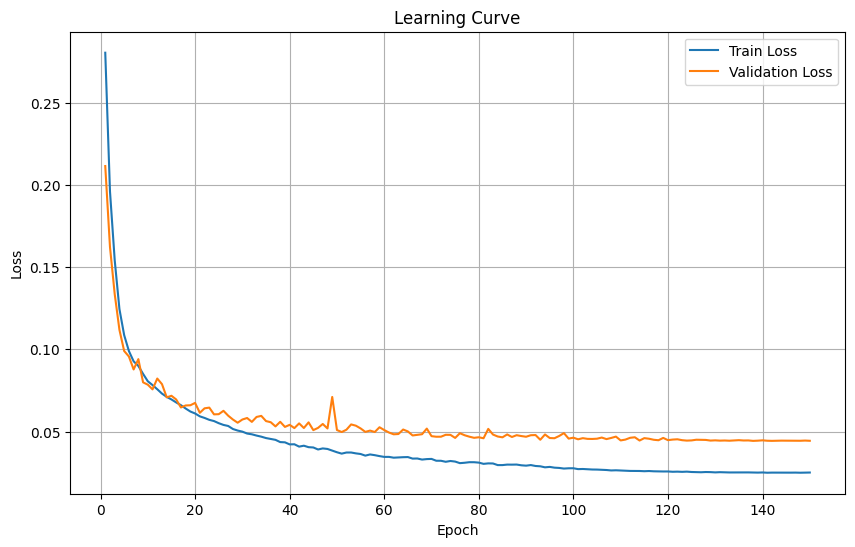

Evaluation AUC: 0.8127153634774653


In [13]:
 if __name__ == "__main__":
    args = get_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu)
    set_seed(2025)
    train_and_evaluate(args)

In [ ]:
import torch
import pandas as pd
import os
import torch.nn.functional as F
from sklearn import metrics

# 만약 get_eval_loader, get_args, DAEModel 등이 별도 모듈에 있다면 import 필요
# from your_module import get_args, get_eval_loader, DAEModel

# 인자 초기화 및 장치 설정
args = get_args()  # get_args() 함수는 기본 인자 값을 반환해야 합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DAEModel(dropout=args.dropout).to(device)
model_path = os.path.join(args.model_dir, args.model_path)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 평가 데이터 로더 준비 (pin_memory 및 num_workers 옵션 적용)
eval_loader, file_list = get_eval_loader(args, pin_memory=True, num_workers=args.n_workers)
criterion = torch.nn.MSELoss(reduction='none')  # reduction 없이 per-element loss 계산

results = []
y_true = []
y_pred = []

# 평가 루프
for idx, data in enumerate(eval_loader):
    spec = data[0].to(device)
    anomaly_label = data[1]  # 배치 내 여러 샘플일 수 있음
    with torch.no_grad():
        recon_spec = model(spec)
        # 각 샘플별 reconstruction error 계산 (배치 차원 유지)
        loss_tensor = F.mse_loss(recon_spec, spec, reduction='none')
        loss_tensor = loss_tensor.mean(dim=[1, 2, 3])  # 각 샘플별 평균 MSE

    # 배치 내 각 샘플 처리
    batch_size = spec.size(0)
    for i in range(batch_size):
        file_index = idx * batch_size + i
        file_name = file_list[file_index] if file_index < len(file_list) else f"unknown_{file_index}"
        sample_loss = loss_tensor[i].item()
        # anomaly_label가 배치 형태이면 개별 값 추출
        label_value = anomaly_label[i].item() if anomaly_label.dim() > 0 else anomaly_label.item()
        results.append([file_name, label_value, sample_loss])
        y_true.append(1 if label_value > 0 else 0)
        y_pred.append(sample_loss)

# 결과를 CSV 파일로 저장
df_results = pd.DataFrame(results, columns=["File Name", "Anomaly Label", "Loss"])
csv_file_path = os.path.join(args.result_dir, "test_results_dae_13.csv")
df_results.to_csv(csv_file_path, index=False)
print(f"테스트가 완료되었습니다. 결과는 {csv_file_path}에 저장되었습니다.")

# AUC 계산
pr_auc = metrics.average_precision_score(y_true, y_pred)
roc_auc = metrics.roc_auc_score(y_true, y_pred)

print(f"Evaluation PR AUC: {pr_auc:.4f}")
print(f"Evaluation ROC AUC: {roc_auc:.4f}")


## 평가 데이터 바꿔서 모델 가중치 불러오기

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
import torchaudio

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 데이터 경로 설정
eval_dir = "/content/ICSV31AIChallengeDataset/eval"

# 모델 생성 및 가중치 불러오기
model = DAEModel().to(device)

checkpoint_path = "/content/drive/MyDrive/model_dae_b.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print("모델 가중치 로드 완료")

#######################
# 데이터 로드 함수 (디렉토리 문제 해결)
#######################
def get_eval_loader(eval_dir: str) -> tuple:
    """ 새로운 평가 데이터 로드 (오디오 파일만 포함) """
    file_list = sorted(os.listdir(eval_dir))

    # 오직 ".wav" 파일만 포함 (디렉토리 제외)
    file_list = [os.path.join(eval_dir, f) for f in file_list if f.endswith(".wav")]

    if not file_list:
        raise ValueError(f"{eval_dir}에 유효한 .wav 파일이 없습니다.")

    dataset = EvalDataset(file_list)
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0), file_list

#######################
# Dataset 클래스 (STFT 변환 포함)
#######################
class EvalDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=512, power=2.0)

        # 정답 라벨 추출 (파일명 기반)
        anomaly_label = 1 if "anomaly" in wav_path else 0

        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        """ 오디오 파일을 로그 STFT 변환 """
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)  # 정규화
        return log_spec

#######################
# 평가 데이터 로드
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        # 수정된 부분: `.item()` 대신 `.tolist()` 사용
        y_true.extend(anomaly_label.view(-1).tolist())  # 개별적으로 저장
        y_pred.extend(loss.view(-1).tolist())  # 개별적으로 저장

# AUC 점수 계산
auc_score = roc_auc_score(y_true, y_pred)
print(f"새로운 평가 데이터 ({eval_dir})에서 AUC Score: {auc_score:.4f}")


모델 가중치 로드 완료
새로운 평가 데이터셋을 사용하여 AUC 계산 중...
새로운 평가 데이터 (/content/ICSV31AIChallengeDataset/eval)에서 AUC Score: 0.4840


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, confusion_matrix, roc_curve
import torchaudio
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 평가 데이터 경로 설정
eval_dir = "/content/ICSV31AIChallengeDataset/eval"

# 모델 생성 및 가중치 불러오기
dropout = 0.05  # args 없이 직접 설정
model = DAEModel(dropout=dropout).to(device)

checkpoint_path = "/content/drive/MyDrive/model_dae_b0319.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=False)
model.eval()
print("모델 가중치 로드 완료")

#######################
# 데이터 로드 함수
#######################
def get_eval_loader(eval_dir: str) -> tuple:
    """ 평가 데이터 로드 (오디오 파일만 포함) """
    file_list = sorted(os.listdir(eval_dir))
    file_list = [os.path.join(eval_dir, f) for f in file_list if f.endswith(".wav")]

    if not file_list:
        raise ValueError(f"{eval_dir}에 유효한 .wav 파일이 없습니다.")

    dataset = EvalDataset(file_list)
    return DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0), file_list

#######################
# Dataset 클래스 (STFT 변환 포함)
#######################
class EvalDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        wav_path = self.file_list[idx]
        spec = self.wav_to_log_stft(wav_path, sr=16000, n_fft=2048, win_length=512, hop_length=256, power=2.0)

        # 정답 라벨 추출 (파일명 기반)
        anomaly_label = 1 if "anomaly" in wav_path else 0

        return spec, anomaly_label

    @staticmethod
    def wav_to_log_stft(wav_path: str, sr: int, n_fft: int, win_length: int, hop_length: int, power: float) -> torch.Tensor:
        """ 오디오 파일을 로그 STFT 변환 """
        stft_transform = torchaudio.transforms.Spectrogram(
            n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=power
        )
        wav_data, _ = torchaudio.load(wav_path)
        spec = stft_transform(wav_data)
        amp_to_db = torchaudio.transforms.AmplitudeToDB()
        log_spec = amp_to_db(spec)
        log_spec = (log_spec - log_spec.mean()) / (log_spec.std() + 1e-9)  # 정규화
        return log_spec

#######################
# 평가 데이터 로드
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

#######################
# 평가 지표 계산
#######################
eval_loader, file_list = get_eval_loader(eval_dir)

# 손실 함수 설정
criterion = nn.MSELoss()

# AUC 계산을 위한 리스트 초기화
y_true, y_pred = [], []

print("새로운 평가 데이터셋을 사용하여 AUC 계산 중...")
with torch.no_grad():
    for idx, data in enumerate(eval_loader):
        spec = data[0].to(device)  # 입력 데이터 (로그 STFT)
        anomaly_label = data[1]  # 정답 라벨 (정상=0, 이상=1)

        decoded = model(spec)
        loss = criterion(decoded, spec)  # MSE 기반 이상 탐지 점수

        y_true.append(anomaly_label.item())  # 정상: 0, 이상: 1
        y_pred.append(loss.item())

# AUC 점수 계산
auc_score = roc_auc_score(y_true, y_pred)
print(f"평가 데이터 ({eval_dir})에서 AUC Score: {auc_score:.4f}")


모델 가중치 로드 완료
새로운 평가 데이터셋을 사용하여 AUC 계산 중...
새로운 평가 데이터셋을 사용하여 AUC 계산 중...
평가 데이터 (/content/ICSV31AIChallengeDataset/eval)에서 AUC Score: 0.4974
